In [1]:
import generate_datasets as ds
from MNIST_functions import *

In [2]:
permuted_train_loaders, permuted_test_loaders, rotated_train_loaders, rotated_test_loaders = ds.load_datasets()

In [3]:
epoch_accuracies_A1, epoch_accuracies_B1, epoch_accuracies_C1, epoch_accuracies_A2, epoch_accuracies_B2, epoch_accuracies_C2, epoch_accuracies_A3, epoch_accuracies_B3, epoch_accuracies_C3,  epoch_accuracies_A1_ewc, epoch_accuracies_B1_ewc, epoch_accuracies_C1_ewc, epoch_accuracies_A2_ewc, epoch_accuracies_B2_ewc, epoch_accuracies_C2_ewc, epoch_accuracies_A3_ewc, epoch_accuracies_B3_ewc, epoch_accuracies_C3_ewc, epoch_accuracies_A1_L2, epoch_accuracies_B1_L2, epoch_accuracies_C1_L2, epoch_accuracies_A2_L2, epoch_accuracies_B2_L2, epoch_accuracies_C2_L2, epoch_accuracies_A3_L2, epoch_accuracies_B3_L2, epoch_accuracies_C3_L2 = run_experiment_2A( permuted_train_loaders, permuted_test_loaders)

Learning rate: 0.001, Dropout input: 0.0, Dropout hidden: 0.0, Early stopping: False, Num hidden layers: 2, Width hidden layers: 400, Epochs: 3
Epoch 1/3, Accuracy on test set A: 0.9372
Epoch 2/3, Accuracy on test set A: 0.9541
Epoch 3/3, Accuracy on test set A: 0.9581


Epoch 1/3, Accuracy on test set B: 0.9308
Epoch 1/3, Accuracy on test set A: 0.9089
Epoch 2/3, Accuracy on test set B: 0.9507
Epoch 2/3, Accuracy on test set A: 0.8957
Epoch 3/3, Accuracy on test set B: 0.9599
Epoch 3/3, Accuracy on test set A: 0.8845


Epoch 1/3, Accuracy on test set C: 0.9402
Epoch 1/3, Accuracy on test set B: 0.9290
Epoch 1/3, Accuracy on test set A: 0.8059
Epoch 2/3, Accuracy on test set C: 0.9502
Epoch 2/3, Accuracy on test set B: 0.8999
Epoch 2/3, Accuracy on test set A: 0.7595
Epoch 3/3, Accuracy on test set C: 0.9619
Epoch 3/3, Accuracy on test set B: 0.8988
Epoch 3/3, Accuracy on test set A: 0.7719


Epoch 1/3, Accuracy on test set A: 0.9381
Epoch 2/3, Accuracy on test set A: 0.9554
Epoch 3/3,

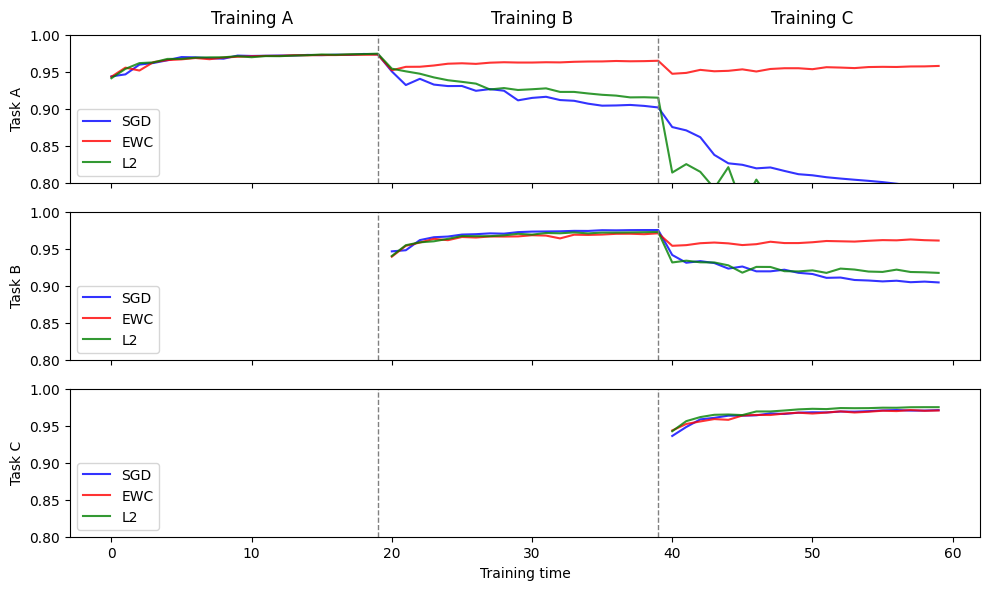

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sgd_A = [epoch_accuracies_A1, epoch_accuracies_A2, epoch_accuracies_A3] 
ewc_A = [epoch_accuracies_A1_ewc, epoch_accuracies_A2_ewc, epoch_accuracies_A3_ewc] 
l2_A = [epoch_accuracies_A1_L2, epoch_accuracies_A2_L2, epoch_accuracies_A3_L2] 

sgd_B = [epoch_accuracies_B1, epoch_accuracies_B2, epoch_accuracies_B3] 
ewc_B = [epoch_accuracies_B1_ewc, epoch_accuracies_B2_ewc, epoch_accuracies_B3_ewc] 
l2_B = [epoch_accuracies_B1_L2, epoch_accuracies_B2_L2, epoch_accuracies_B3_L2] 

sgd_C = [epoch_accuracies_C1, epoch_accuracies_C2, epoch_accuracies_C3] 
ewc_C = [epoch_accuracies_C1_ewc, epoch_accuracies_C2_ewc, epoch_accuracies_C3_ewc] 
l2_C = [epoch_accuracies_C1_L2, epoch_accuracies_C2_L2, epoch_accuracies_C3_L2] 

# Flatten each list (SGD, EWC, L2) into a single list of accuracies for each task
sgd_A_flat = [item for sublist in sgd_A for item in sublist]
ewc_A_flat = [item for sublist in ewc_A for item in sublist]
l2_A_flat = [item for sublist in l2_A for item in sublist]

sgd_B_flat = [item for sublist in sgd_B for item in sublist]
ewc_B_flat = [item for sublist in ewc_B for item in sublist]
l2_B_flat = [item for sublist in l2_B for item in sublist]

sgd_C_flat = [item for sublist in sgd_C for item in sublist]
ewc_C_flat = [item for sublist in ewc_C for item in sublist]
l2_C_flat = [item for sublist in l2_C for item in sublist]

# Create time arrays for the x-axis 
max_len_A = len(sgd_A_flat)  # The total number of points for Task A
time_A = np.arange(max_len_A)

# Task B and C - create time arrays based on the available epochs
max_len_B = len(sgd_B_flat)
time_B = np.arange(max_len_B)

max_len_C = len(sgd_C_flat)
time_C = np.arange(max_len_C)

# Padding with NaNs for Task B (before the last 40 epochs) and Task C (before the last 20 epochs)
sgd_B_padded = [np.nan] * (max_len_A - max_len_B) + sgd_B_flat
ewc_B_padded = [np.nan] * (max_len_A - max_len_B) + ewc_B_flat
l2_B_padded = [np.nan] * (max_len_A - max_len_B) + l2_B_flat

sgd_C_padded = [np.nan] * (max_len_A - max_len_C) + sgd_C_flat
ewc_C_padded = [np.nan] * (max_len_A - max_len_C) + ewc_C_flat
l2_C_padded = [np.nan] * (max_len_A - max_len_C) + l2_C_flat

# Adjust time arrays for Task B and C based on the length of padded data
time_B_padded = np.arange(len(sgd_B_padded))
time_C_padded = np.arange(len(sgd_C_padded))

# Set up subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Colors for the methods
colors = {'ewc': 'red', 'l2': 'green', 'sgd': 'blue'}

# Plot Task A
axes[0].plot(time_A, sgd_A_flat, label="SGD", color=colors['sgd'], alpha=0.8)
axes[0].plot(time_A, ewc_A_flat, label="EWC", color=colors['ewc'], alpha=0.8)
axes[0].plot(time_A, l2_A_flat, label="L2", color=colors['l2'], alpha=0.8)
axes[0].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[0].set_ylabel("Task A")
axes[0].set_ylim(0.8, 1)
axes[0].legend(loc="lower left")
axes[0].text(10, 1.01, "Training A", ha='center', va='bottom', fontsize=12)
axes[0].text(30, 1.01, "Training B", ha='center', va='bottom', fontsize=12)
axes[0].text(50, 1.01, "Training C", ha='center', va='bottom', fontsize=12)

# Plot Task B
axes[1].plot(time_B_padded, sgd_B_padded, label="SGD", color=colors['sgd'], alpha=0.8)
axes[1].plot(time_B_padded, ewc_B_padded, label="EWC", color=colors['ewc'], alpha=0.8)
axes[1].plot(time_B_padded, l2_B_padded, label="L2", color=colors['l2'], alpha=0.8)
axes[1].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[1].set_ylabel("Task B")
axes[1].set_ylim(0.8, 1)
axes[1].legend(loc="lower left")

# Plot Task C
axes[2].plot(time_C_padded, sgd_C_padded, label="SGD", color=colors['sgd'], alpha=0.8)
axes[2].plot(time_C_padded, ewc_C_padded, label="EWC", color=colors['ewc'], alpha=0.8)
axes[2].plot(time_C_padded, l2_C_padded, label="L2", color=colors['l2'], alpha=0.8)
axes[2].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[2].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[2].set_xlabel("Training time")
axes[2].set_ylabel("Task C")
axes[2].set_ylim(0.8, 1)
axes[2].legend(loc="lower left")

# Show the plot
plt.tight_layout()
plt.show()

Trial 1/1: Learning rate=0.00009, Hidden layer width=1044
Training on Task 1
Task 1, Epoch 1/10, SGD Loss: 0.0010
Task 1, Epoch 1/10, EWC Loss: 0.0009
Task 1, Epoch 2/10, SGD Loss: 0.0011
Task 1, Epoch 2/10, EWC Loss: 0.0007
Task 1, Epoch 3/10, SGD Loss: 0.0009
Task 1, Epoch 3/10, EWC Loss: 0.0011
Task 1, Epoch 4/10, SGD Loss: 0.0007
Task 1, Epoch 4/10, EWC Loss: 0.0005
Task 1, Epoch 5/10, SGD Loss: 0.0006
Task 1, Epoch 5/10, EWC Loss: 0.0004
Task 1, Epoch 6/10, SGD Loss: 0.0004
Task 1, Epoch 6/10, EWC Loss: 0.0004
Task 1, Epoch 7/10, SGD Loss: 0.0002
Task 1, Epoch 7/10, EWC Loss: 0.0004
Task 1, Epoch 8/10, SGD Loss: 0.0007
Task 1, Epoch 8/10, EWC Loss: 0.0011
Task 1, Epoch 9/10, SGD Loss: 0.0004
Task 1, Epoch 9/10, EWC Loss: 0.0006
Task 1, Epoch 10/10, SGD Loss: 0.0004
Task 1, Epoch 10/10, EWC Loss: 0.0003
Training on Task 2
Task 2, Epoch 1/10, SGD Loss: 0.0011
Task 2, Epoch 1/10, EWC Loss: 0.0011
Task 2, Epoch 2/10, SGD Loss: 0.0010
Task 2, Epoch 2/10, EWC Loss: 0.0010
Task 2, Epoch 

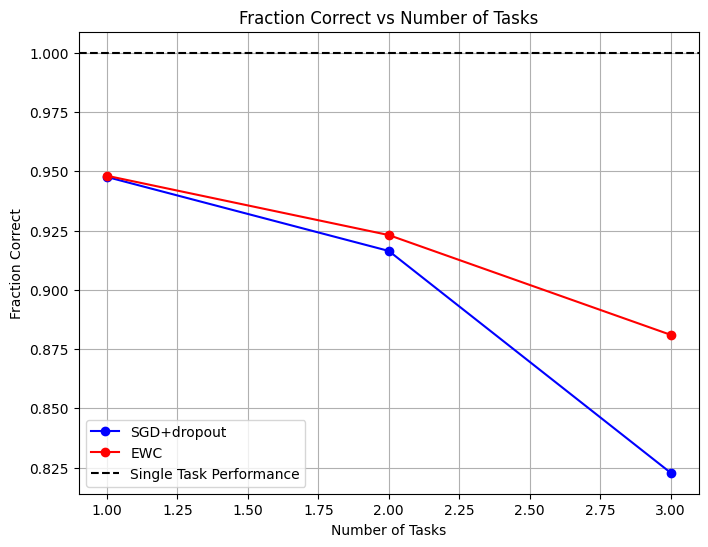

(None, None)

In [3]:
run_experiment_2B_with_ewc_and_plot(permuted_train_loaders[0:3],permuted_test_loaders[0:3])